This notebook has been used to time profile the GA to be able to improve the time efficiency of the algorithm.

Two test are done:
1. GA without network metrics
2. Ga WITH network metrics at alpha={0, 0.5, 0.99}. Alpha=1 is way faster due to the GA implementation.

---
Author: Jordi Grau Escolano


# 1. Load data

In [2]:
import sys
import os
import multiprocessing as mp
from functools import partial
import time
from pathlib import Path
import numpy as np  # type: ignore
import pandas as pd  # type: ignore
import geopandas as gpd  # type: ignore
from shapely import wkt  # type: ignore
import matplotlib.pyplot as plt  # type: ignore
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable  # type: ignore
import contextily as ctx  # type: ignore

# Add project root to path
project_root = Path().resolve().parents[0]
sys.path.insert(0, str(project_root))
print(project_root)

from paths import *
import src.data_loader as dl
import src.optimization.GA.GA as ga # type: ignore
import src.optimization.helper_optimization as ho # type: ignore
import src.optimization.experiments.helper_experiment as he # type: ignore

ROOT = '../'

# 1. Load configuration
df, G, distance_matrix, id_to_idx, idx_to_id, distance_matrix_binary, STATION_MIN_DISTANCE = he.load_data(root=ROOT)
EPSG = 25831

POPULATION_SIZE = 50
GENERATIONS = 100
MUTATION_RATE = 0.05
ELITE_PROPORTION = 0.05
SELECTION_STRATEGY = 'tournament'
CROSSOVER_STRATEGY = 'greedy'
N_STATIONS = 50

WEIGHTS = {'population': 1}

# Generate initial population (keep multiprocessing for this step)
t_start = time.time()
initial_population = ho.generate_initial_population(
    N_STATIONS, POPULATION_SIZE, distance_matrix, 
    id_to_idx, STATION_MIN_DISTANCE, n_jobs=-1
)
print(f"Initial population generated in {time.time() - t_start:.2f} seconds")

# Compute and normalize scores according to weights
df_weighted = ho.sum_and_normalize_all_node_scores(df.copy(), WEIGHTS)

for selected_nodes in initial_population:
    if not ho.validate_solution(
        selected_nodes, distance_matrix, id_to_idx, idx_to_id, N_STATIONS, STATION_MIN_DISTANCE):
        print(f"Invalid solution: {selected_nodes}")

/home
	Successfully loaded graph bike_graph with protocol 5
Loading existing node attributes from ..//data/processed/nodes/node_attributes.csv
Loading pre-computed distance matrix and mappings...
	Successfully loaded mappings with protocol 5
Successfully loaded distance matrix of shape (18721, 18721)
Initial population generated in 15.83 seconds


In [3]:
def plot_nodes(df_weighted, ax, bcn_boundary, show_colorbar=True, show_normalization_raw_score=False):
    """
    Plot all nodes on a map
    """
    if bcn_boundary is not None:
        bcn_boundary.boundary.plot(ax=ax, color='black', alpha=0.7)

    # Plot stations
    scatter =df_weighted.plot(
                column='norm_score',
                cmap=plt.cm.viridis_r,
                ax=ax,
                markersize=0.5,
                legend=False,
                vmin=0, vmax=1)

    # Add colorbar
    if show_colorbar:
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="3%", pad=0.05)
        cbar = plt.colorbar(scatter.collections[0], cax=cax)
        cbar.ax.tick_params(labelsize=8)
        if show_normalization_raw_score:
            original_min, original_max = df_weighted["norm_score"].min(), df_weighted["norm_score"].max()
            cbar.ax.set_ylabel(f'Score (min={original_min:.2f}, max={original_max:.2f})', fontsize=8)

    ax.set_axis_off()

# 2. WITHOUT GRAPH METRICS

In [4]:
%%prun -s cumtime

generations = 100
best_nodes_ga, best_score_ga, ga_tracking = ga.genetic_algorithm(
    df=df_weighted,
    population=initial_population,
    distance_matrix=distance_matrix,
    station_min_distance=STATION_MIN_DISTANCE,
    id_to_idx=id_to_idx,
    idx_to_id=idx_to_id,
    generations=generations,
    elite_proportion=ELITE_PROPORTION,
    mutation_rate=MUTATION_RATE,
    selection_strategy=SELECTION_STRATEGY,
    crossover_strategy=CROSSOVER_STRATEGY,
    G=G,
    metric_bounds=(0, 0),
    graph_score=False,
    alpha=0.5,
    score_combination='multiply',
    penalty_power=2,
    logging_rate=10
)

16:46 | Gen 2 | Bst Sc = 38.79 | Avg Sc = 36.67 |  Std Sc = 1.89 | Jaccard = 0.956
 

         1734278 function calls (1714671 primitive calls) in 3.561 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     97/1    0.002    0.000    3.562    3.562 {built-in method builtins.exec}
        1    0.002    0.002    3.561    3.561 GA.py:129(genetic_algorithm)
       98    0.002    0.000    3.069    0.031 GA.py:63(crossover)
       98    0.091    0.001    3.067    0.031 helper_crossover_old.py:72(_crossover_greedy)
     4900    0.211    0.000    2.721    0.001 helper_crossover_old.py:84(<listcomp>)
   358250    0.860    0.000    2.510    0.000 helper_crossover_old.py:24(_is_feasible)
        2    0.000    0.000    0.724    0.362 dispatcher.py:344(_compile_for_args)
   358702    0.718    0.000    0.718    0.000 {built-in method numpy.array}
        2    0.000    0.000    0.700    0.350 dispatcher.py:858(compile)
        1    0.000    0.000    0.661    0.661 dispatcher.py:79(compile)
        1    0.000    0.000    0.

# 3. WITH GRAPH METRICS

In [5]:
import src.optimization.GA.graph_metric.graph_normalization as gn

min_disp_bound, _ = gn.min_dispersion_bound(N_STATIONS, STATION_MIN_DISTANCE)
max_disp_metric, _ = gn.max_dispersion_metric(N_STATIONS, distance_matrix, STATION_MIN_DISTANCE, idx_to_id)
min_accessibility_bound, _ = gn.min_accessibility_bound_kmeans(G, N_STATIONS, distance_matrix, id_to_idx)
max_accessibility_bound, _ = gn.max_accessibility_bound(N_STATIONS, distance_matrix, idx_to_id, STATION_MIN_DISTANCE)
dispersion_bounds = (min_disp_bound, max_disp_metric)
accessibility_bounds = (min_accessibility_bound, max_accessibility_bound)

In [ ]:
%%prun -s cumtime

best_nodes_ga_alpha_0, best_score_ga_alpha_0, ga_tracking_alpha_0 = ga.genetic_algorithm(
    df=df_weighted,
    population=initial_population,
    distance_matrix=distance_matrix,
    station_min_distance=STATION_MIN_DISTANCE,
    id_to_idx=id_to_idx,
    idx_to_id=idx_to_id,
    generations=generations,
    elite_proportion=ELITE_PROPORTION,
    mutation_rate=MUTATION_RATE,
    selection_strategy=SELECTION_STRATEGY,
    crossover_strategy=CROSSOVER_STRATEGY,
    G=G,
    metric_bounds=(dispersion_bounds, accessibility_bounds),
    graph_score=True,
    alpha=0,
    score_combination='multiply',
    penalty_power=2,
    logging_rate=10
)

In [ ]:
%%prun -s cumtime

best_nodes_ga_alpha_05, best_score_ga_alpha_05, ga_tracking_alpha_05 = ga.genetic_algorithm(
    df=df_weighted,
    population=initial_population,
    distance_matrix=distance_matrix,
    station_min_distance=STATION_MIN_DISTANCE,
    id_to_idx=id_to_idx,
    idx_to_id=idx_to_id,
    generations=generations,
    elite_proportion=ELITE_PROPORTION,
    mutation_rate=MUTATION_RATE,
    selection_strategy=SELECTION_STRATEGY,
    crossover_strategy=CROSSOVER_STRATEGY,
    G=G,
    metric_bounds=(dispersion_bounds, accessibility_bounds),
    graph_score=True,
    alpha=0.5,
    score_combination='multiply',
    penalty_power=2,
    logging_rate=10
)

16:46 | Gen 2 | Bst Sc = 32.66 | Avg Sc = 29.83 |  Std Sc = 2.20 | Jaccard = 0.954
 

         1217855 function calls in 3.521 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    3.522    3.522 {built-in method builtins.exec}
        1    0.000    0.000    3.521    3.521 <string>:1(<module>)
        1    0.002    0.002    3.521    3.521 GA.py:129(genetic_algorithm)
       98    0.002    0.000    2.652    0.027 GA.py:63(crossover)
       98    0.105    0.001    2.649    0.027 helper_crossover_old.py:72(_crossover_greedy)
     4900    0.269    0.000    2.287    0.000 helper_crossover_old.py:84(<listcomp>)
   356900    0.958    0.000    2.018    0.000 helper_crossover_old.py:24(_is_feasible)
   357361    0.788    0.000    0.788    0.000 {built-in method numpy.array}
        2    0.001    0.000    0.455    0.228 helper_optimization.py:446(calculate_population_scores)
        2    0.000    0.000    0.438    0.219 helper_optimization.py:414(calculate_graph_scores)
        2    0.001   

In [8]:
%%prun -s cumtime

best_nodes_ga_alpha_099, best_score_ga_alpha_099, ga_tracking_alpha_099 = ga.genetic_algorithm(
    df=df_weighted,
    population=initial_population,
    distance_matrix=distance_matrix,
    station_min_distance=STATION_MIN_DISTANCE,
    id_to_idx=id_to_idx,
    idx_to_id=idx_to_id,
    generations=generations,
    elite_proportion=ELITE_PROPORTION,
    mutation_rate=MUTATION_RATE,
    selection_strategy=SELECTION_STRATEGY,
    crossover_strategy=CROSSOVER_STRATEGY,
    G=G,
    metric_bounds=(dispersion_bounds, accessibility_bounds),
    graph_score=True,
    alpha=0.99,
    score_combination='multiply',
    penalty_power=2,
    logging_rate=10
)

16:46 | Gen 2 | Bst Sc = 28.41 | Avg Sc = 24.87 |  Std Sc = 2.31 | Jaccard = 0.947
 

         1212083 function calls in 3.235 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    3.235    3.235 {built-in method builtins.exec}
        1    0.001    0.001    3.235    3.235 <string>:1(<module>)
        1    0.002    0.002    3.234    3.234 GA.py:129(genetic_algorithm)
       98    0.003    0.000    2.386    0.024 GA.py:63(crossover)
       98    0.093    0.001    2.383    0.024 helper_crossover_old.py:72(_crossover_greedy)
     4900    0.212    0.000    2.042    0.000 helper_crossover_old.py:84(<listcomp>)
   354950    0.869    0.000    1.830    0.000 helper_crossover_old.py:24(_is_feasible)
   355450    0.711    0.000    0.711    0.000 {built-in method numpy.array}
        2    0.001    0.000    0.409    0.205 helper_optimization.py:446(calculate_population_scores)
        2    0.000    0.000    0.393    0.196 helper_optimization.py:414(calculate_graph_scores)
        2    0.001   

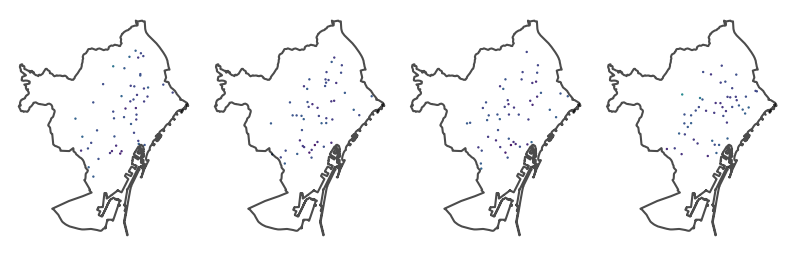

In [9]:
fig, axs = plt.subplots(1,4, figsize=(10, 4), gridspec_kw={'wspace': 0.05})


bcn_boundary = dl.load_bcn_boundary()

plot_nodes(df_weighted[df_weighted.index.isin(best_nodes_ga)], 
           axs[0], bcn_boundary, show_colorbar=False, show_normalization_raw_score=False)
plot_nodes(df_weighted[df_weighted.index.isin(best_nodes_ga_alpha_0)], 
           axs[1], bcn_boundary, show_colorbar=False, show_normalization_raw_score=False)
plot_nodes(df_weighted[df_weighted.index.isin(best_nodes_ga_alpha_05)], 
           axs[2], bcn_boundary, show_colorbar=False, show_normalization_raw_score=False)
plot_nodes(df_weighted[df_weighted.index.isin(best_nodes_ga_alpha_099)], 
           axs[3], bcn_boundary, show_colorbar=False, show_normalization_raw_score=False)
plt.show()